<a href="https://colab.research.google.com/github/CeliaDiazSanchez/APRENDIZAJE_AUTOMATICO_23_24/blob/main/Pr%C3%A1ctica_3_Redes_de_Neuronas_Convolucionales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Práctica 3 - Redes de Neuronas Convolucionales**
**Grupo**: B03

**Integrantes**: Celia Díaz, Jaime Martínez, Claudia Esnarrizaga

**Profesor**: Carlos Emilio Rabazo

**Curso**: 3ºB Ingeniería Matemática


##**Enunciado**

Crea un modelo de Red de Neuronas **Convolucionales** que sea capaz de **reconocer y clasificar imágenes en 100 categorías**. Este modelo será **definido, configurado, entrenado, evaluado y mejorado** para posteriormente usarlo para hacer predicciones.
Para ello tendréis que crear un modelo en **Keras** aplicando de una tirada todos los pasos
al conjunto de datos **CIFAR-100 dataset**, que os podréis descargar de
https://www.cs.toronto.edu/~kriz/cifar.html.
Este conjunto de datos tiene 100 clases que contienen 600 imágenes cada una. Hay 500
imágenes de entrenamiento y 100 imágenes de prueba por clase. Las 100 clases del
CIFAR-100 se agrupan en 20 superclases. Cada imagen viene con una etiqueta "fina" (la clase a la que pertenece) y una etiqueta "gruesa" (la superclase a la que pertenece).

###**Cuestiones a tener en cuenta**

1. Decidir la estructura de la red neuronal convolucional (número de parámetros) y los valores de todos los hiperparámetros que permitan tener la mayor precisión en los datos de test.
2. Asegurar la salida de la llamada *model.summary()* de nuestra red definitiva.
3. Seguir los modelos metodológicos vistos en clase (sobre un modelo base, ir incrementando la complejidad para mejorar el modelo hasta donde se pueda).
4. Ver los conceptos de *batch_normalization* y *dropout* y ver si se podría mejorar el modelo con ello.
5. Ver los conceptos de *callbacks* (Decaimiento del ratio de aprendizaje) y ver si se podría mejorar el modelo con ello.




## **Resolución**

###**Carga de librerías y datos**

In [24]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.14.0


Cargamos todas las librerías necesarias

In [25]:
from keras.datasets import cifar100
from keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Nadam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from keras import regularizers
import numpy as np
import matplotlib.pyplot as plt

Cargamos nuestros datos

In [26]:
# CARGAMOS EL CONJUNTO DE DATOS CIFAR-100 EN KERAS
(train_images, train_labels), (test_images, test_labels) = cifar100.load_data() # Llama a una función, cargar datos

###**Estudio previo**

Vamos a ver qué pinta tienen nuestros datos

In [27]:
# Obtener información sobre el conjunto de entrenamiento
print("Shape del conjunto de entrenamiento (imágenes):", train_images.shape)
print("Shape del conjunto de entrenamiento (etiquetas):", train_labels.shape)
print("Número de clases en CIFAR-100:", len(set(train_labels.flatten())))

# Obtener información sobre el conjunto de prueba
print("Shape del conjunto de prueba (imágenes):", test_images.shape)
print("Shape del conjunto de prueba (etiquetas):", test_labels.shape)

Shape del conjunto de entrenamiento (imágenes): (50000, 32, 32, 3)
Shape del conjunto de entrenamiento (etiquetas): (50000, 1)
Número de clases en CIFAR-100: 100
Shape del conjunto de prueba (imágenes): (10000, 32, 32, 3)
Shape del conjunto de prueba (etiquetas): (10000, 1)


Conclusiones que podemos sacar:
- Tamaño del Conjunto de Datos: El conjunto de entrenamiento consta de 50000 imágenes, mientras que el conjunto de prueba tiene 10000 imágenes. Esto es típico en la configuración de conjuntos de datos para el aprendizaje supervisado.
- Resolución de las Imágenes: Cada imagen tiene una resolución de 32x32 píxeles, lo que indica que las imágenes son relativamente pequeñas. Este tamaño más pequeño puede facilitar el entrenamiento rápido de modelos, pero también puede presentar desafíos en la capacidad del modelo para capturar detalles.
- Canales de Color: Las imágenes son imágenes en color con 3 canales (RGB). Cada píxel se representa con tres valores correspondientes a la intensidad de los componentes rojo, verde y azul.
- Número de Clases: El conjunto de datos **CIFAR-100** consta de 100 clases diferentes. Esto significa que cada imagen tiene una etiqueta que pertenece a una de las 100 categorías.
- Dimensiones de las Etiquetas: Las dimensiones del tensor de etiquetas muestran que cada etiqueta es un valor único asociado a cada imagen. La forma **(50000, 1)** indica lo mismo para el conjunto de prueba.
- Preprocesamiento: puede ser necesario realizar algún tipo de preprocesamiento, como normalización de píxeles, para preparar los datos antes de entrenar un modelo.

Además, podemos observar que tenemos 60000 imágenes (500000 de entrenamiento y 100000 de test), entre las 100 clases que contiene nuestra base de datos, nos quedaríamos con 6000 imágenes por etiqueta, lo cual es un número más o menos bajo teniendo en cuenta que son imágenes muy variadas y a color. Esto nos lleva a suponer que nuestra red va a tener complicado alcanzar un aprendizaje alto.

Vamos a imprimir 10 imágenes aleatorias para ver qué pinta tienen. Para ello, generaremos 10 índices aleatorios del conjunto de entrenamiento.

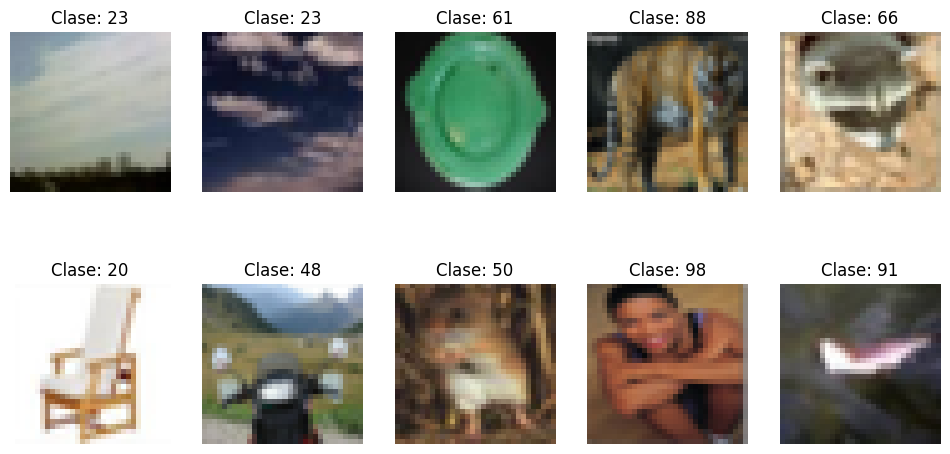

In [28]:
# Obtener índices aleatorios
random_indices = np.random.choice(len(train_images), size=10, replace=False)

# Crear una cuadrícula de 2x5 para mostrar las imágenes
plt.figure(figsize=(12, 6))
for i, index in enumerate(random_indices, 1):
    plt.subplot(2, 5, i)
    plt.imshow(train_images[index])
    plt.title(f"Clase: {train_labels[index][0]}")
    plt.axis('off')

plt.show()

Normalizamos los datos

In [29]:
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

Convertimos las etiquetas a one-hot encoding

In [30]:
train_labels_one_hot = to_categorical(train_labels)
test_labels_one_hot = to_categorical(test_labels)

###**División entrenamiento - validación**

Dividimos el conjunto de entrenamiento en entrenamiento y validación. Esto nos puede traer las siguientes ventajas:

- Evita el Sobreajuste: separar un conjunto de datos en conjuntos de entrenamiento y validación ayuda a detectar si el modelo está sobreajustando. Al tener un conjunto de validación independiente, podemos ver si el rendimiento en la validación mejora o empeora durante el entrenamiento, lo que nos permite ajustar la complejidad del modelo.
- Evaluación del Rendimiento: al final del entrenamiento, evaluaremos el rendimiento final del modelo en un conjunto de datos que no ha visto durante el entrenamiento (conjunto de validación). Esto proporciona una estimación más realista de cómo se espera que el modelo se desempeñe en datos del mundo real.
- Generalización del Modelo: al dividir los datos en conjuntos de entrenamiento y validación, se busca construir un modelo que generalice bien a datos nuevos y no vistos, en lugar de simplemente memorizar los datos de entrenamiento.

In [31]:
train_images, val_images, train_labels_one_hot, val_labels_one_hot = train_test_split(
    train_images, train_labels_one_hot, train_size=0.8)

###**Aumento de datos**

El siguiente código utiliza la clase *ImageDataGenerator* de Keras para realizar aumento de datos en conjuntos de imágenes, lo cual es comúnmente utilizado para mejorar el rendimiento de las redes neuronales en tareas de visión por computadora, como clasificación de imágenes (nuestro caso).
A continuación explicaremos los parámetros utilizados:


*   *rotation_range*: rotación aleatoria de la imagen en un rango de 0 a 20 grados.
*   *width_shift_range* y *height_shift_range*: desplazamiento horizontal y vertical aleatorio de la imagen en un rango del 0 al 0.2 (fracción de la dimensión total).
*   *zoom_range*: zoom aleatorio aplicado a la imagen en un rango del 0 al 0.2
*   *horizontal_flip*: volteo horizontal aleatorio de la imagen.

Estas transformaciones crean nuevas versiones de las imágenes de entrenamiento, lo que aumenta la variabilidad del conjunto de datos. Esta variabilidad adicional ayuda a que el modelo generalice mejor, ya que se expone a más variaciones durante el entrenamiento.

En el caso de imágenes a color (nuestro caso), estas transformaciones se aplicarán de manera independiente a cada canal de color, lo que ayuda a mantener la coherencia cromática en las imágenes generadas.

De esta manera, hemos comprobado que es una técnica clave para evitar el sobreajuste y mejorar la capacidad de generalización de los modelos de redes neuronales, especialmente en conjuntos de datos limitados.





In [32]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)
datagen.fit(train_images)

###**Modelo**

Definimos nuestro modelo

Estas 4 capas conforman nuestra primera parte del modelo. Las dos primeras (Conv2D) realizan convoluciones para extraer características, max pooling reduce la dimensionalidad, y batch normalization estabiliza y acelera el entrenamiento.


**Capa Conv2D 1:**

*   input_shape=(32, 32, 3): Esto especifica la forma de los datos de entrada a la red. En este caso, se espera que las imágenes de entrada tengan un tamaño de 32x32 píxeles con 3 canales de color (RGB).
*   kernel_size=(3, 3): El tamaño de la ventana (filtro) que se desliza sobre la entrada. En este caso, es un filtro 3x3.
padding='same': Añade ceros alrededor de la entrada para mantener el mismo tamaño en la salida. Esto se llama "padding" y ayuda a preservar la información en los bordes de la imagen.
*   filters=64: Indica el número de filtros (también conocidos como kernels o características) que se aplicarán. En este caso, hay 64 filtros.
*   activation='relu': La función de activación Rectified Linear Unit (ReLU) se aplica después de la convolución. ReLU es común en redes neuronales convolucionales y ayuda a introducir no linealidades en la red.

**Capa Conv2D 2:**

*   Similar a la primera capa Conv2D, pero no se especifica la forma de entrada (input_shape) porque la red ya "sabe" la forma de entrada desde la capa anterior.
*   La capa convolucional se aplica nuevamente con 64 filtros y la función de activación ReLU.

**Capa MaxPooling2D:**

*   pool_size=(2, 2): Realiza un submuestreo al seleccionar el valor máximo de una ventana 2x2. Esto reduce la dimensionalidad espacial y ayuda a reducir el costo computacional en las capas posteriores de la red.
*   Nos extrae las características más importantes y reduce el tamaño de la representación.

**Capa BatchNormalization:**

- Normaliza la activación de cada filtro en una capa para tener media cercana a cero y desviación estándar cercana a uno. Nos hemos dado cuenta de que el uso de esta capa nos acelera el entrenamiento, estabiliza el aprendizaje y mejora el rendimiento de la red en general.


In [33]:
model = Sequential()
model.add(Conv2D(input_shape=(32, 32, 3), kernel_size=(3, 3), padding='same', filters=64, activation='relu'))
model.add(Conv2D(kernel_size=(3, 3), padding='same', filters=64, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

En el siguiente conjunto de capas, hemos decidido añadir dos capas convolucionales más pero aumentando el número de filtros. Esto ayuda a la red a aprender representaciones más complejas y abstractas. En las capas iniciales, los filtros pueden capturar detalles simples como bordes, texturas, y colores básicos. A medida que avanzamos en capas más profundas, los filtros tienden a aprender representaciones más abstractas y de alto nivel.

Esto nos llevó a pensar que aumentar el número de filtros en las capas convolucionales posteriores puede ayudar a la red a capturar características más complejas y abstractas de las imágenes de entrada.

Además, añadimos otra capa más MaxPooling2D y otra de BatchNormalization.

In [34]:
model.add(Conv2D(kernel_size=(3, 3), padding='same', filters=128, activation='relu'))
model.add(Conv2D(kernel_size=(3, 3), padding='same', filters=128, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

Aplicamos el mismo pensamiento que hemos explicado anteriormente, dos capas convolucionales más aumentando el número de filtros.

Además, añadimos otra capa más MaxPooling2D y otra de BatchNormalization.

In [35]:
model.add(Conv2D(kernel_size=(3, 3), padding='same', filters=256, activation='relu'))
model.add(Conv2D(kernel_size=(3, 3), padding='same', filters=256, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

In [36]:
model.add(Conv2D(kernel_size=(3, 3), padding='same', filters=512, activation='relu'))
model.add(Conv2D(kernel_size=(3, 3), padding='same', filters=512, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

Las capas que añadimos a continuación reduccen la dimensionalidad para pasar de las representaciones espaciales aprendidas por las capas convolucionales a una representación plana que pueda ser utilizada por capas totalmente conectadas (densas). Analicemos cada capa:

**Capa Flatten:**

Convierte la salida de las capas convolucionales (un tensor tridimensional) en un vector unidimensional. Esta capa es necesaria antes de introducir capas densas.

**Capa Dense (512 neuronas):**

Capa completamente conectada con 512 neuronas.
- activation='relu': Utiliza la función de activación ReLU para introducir no linealidades.
- kernel_regularizer=regularizers.l2(0.001): Aplica regularización L2 a los pesos de esta capa. La regularización L2 ayuda a prevenir el sobreajuste penalizando los pesos grandes.

**Capa Dropout (0.5):**

La capa de Dropout apaga aleatoriamente el 50% de las neuronas durante el entrenamiento. Esto ayuda a prevenir el sobreajuste al introducir cierta variabilidad y redundancia en la red.

**Capa BatchNormalization:**

Normaliza la activación de cada capa, similar a lo que hace la capa BatchNormalization después de las capas convolucionales. Nos ayuda a estabilizar y acelerar el entrenamiento.

**Capa Dense (256 neuronas):**

Otra capa completamente conectada con 256 neuronas.
- activation='relu': Utiliza ReLU como función de activación.
- kernel_regularizer=regularizers.l2(0.001): Aplica regularización L2 (técnica utilizada durante el entrenamiento de modelos de aprendizaje automático para prevenir el sobreajuste.

**Capa Dropout (0.5):**

Otra capa Dropout con una tasa del 50%.

**Capa BatchNormalization:**

Otra capa BatchNormalization.

**Capa Dense (100 neuronas con activación softmax):**

Última capa densa con 100 neuronas, que corresponde al número de clases en tu problema.
Utiliza la función de activación softmax (problemas de clasificación multiclase). Produce probabilidades para cada clase y es útil en la salida de la red para la clasificación.

In [37]:
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(100, activation='softmax'))

###**Resumen del modelo**

Ya hemos hecho un estudio más o menos exhaustivo de la red, pero aquí hay una visión más general:

**Arquitectura de la red**

La red consta de varias capas convolucionales, capas de agrupación (max pooling), capas de normalización por lotes (batch normalization), capas totalmente conectadas (densas) y capas de dropout.
Aplicamos la convolución con diferentes tamaños de filtro, lo que, como ya hemos mencionado antes, ayuda a la red aprender características de diferentes escalas.
Las capas de agrupación (max pooling) reducen la dimensión espacial de las representaciones para mejorar la eficiencia computacional.
La normalización por lotes se utiliza para estabilizar y acelerar el entrenamiento.


**Tamaño de entrada y salida**

La entrada de la red es de tamaño 32x32
La última capa densa tiene 100 unidades de salida, ya que nuestro modelo tiene que clasificar entre 100 clases diferentes.


**Parámetros**

El modelo tiene un total de 5,898,404 parámetros.
De estos, 5,894,948 son entrenables, y 3,456 son no entrenables.


**Complejidad del modelo**

La complejidad del modelo se refleja en la cantidad significativa de parámetros, lo que nos sugiere que es un modelo profundo con capacidad para aprender representaciones complejas de datos.


**Regularización**

Se utilizan capas de dropout para evitar el sobreajuste durante el entrenamiento.
La normalización por lotes también puede actuar como una forma de regularización.


**Capas densas finales**

El modelo termina con tres capas densas, reduciendo gradualmente la dimensión de la salida.
La última capa tiene 100 unidades de salida, que coinciden con el número de clases en el problema de clasificación.

In [38]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 batch_normalization_6 (Bat  (None, 16, 16, 64)        256       
 chNormalization)                                                
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 128)      

###**Función *lr_schedule***

La función creada a continuación *lr_schedule* implementa un programa de ajuste del learning rate (tasa de aprendizaje) basado en el número de épocas (epoch).La tasa de aprendizaje disminuirá a medida que aumente el número de épocas según la fórmula $$\text{Tasa de Aprendizaje} = 0.001 \times (0.1^{\lfloor \frac{\text{época}}{40} \rfloor})$$

Es decir, la tasa de aprendizaje se reduce a una décima cada 40 épocas (cuando queden 10 épocas por entrenar).

La idea es comenzar con una tasa de aprendizaje relativamente alta para realizar actualizaciones de peso más grandes al principio del entrenamiento, lo que puede ayudar al modelo a converger más rápidamente. Luego, a medida que el entrenamiento avanza, se reduce gradualmente la tasa de aprendizaje para realizar ajustes más finos y evitar oscilaciones excesivas alrededor del mínimo global.

Esto nos lleva a pensar que por qué no actualizar el *learning_rate* cada menos épocas. Sin embargo, probamos esa opción y aprendía peor, ya que se quedaba estancado y subía muy poco la precisión de los datos de test.


In [39]:
# Learning rate schedule
def lr_schedule(epoch):
    return 0.001 * (0.1 ** int(epoch / 40))

Probamos otros callbacks, como por ejemplo *model_checkpoint*, *reduce_lr* o *early_stopping*. Lo habríamos implementado de la siguiente manera:

In [40]:
# model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)
# history = model.fit(
    # datagen.flow(train_images, train_labels_one_hot, batch_size=128),
    # validation_data=(val_images, val_labels_one_hot),
    # epochs=50,
    # callbacks=[model_checkpoint,early_stopping, reduce_lr])

Los hemos combinado entre ellos pero sin ninguna duda lo que mejor nos funcionaba era hacer nuestra propia función (*lr_schedule*) e ir modificándola según considerábamos.

###**Compilación del modelo**

Ahora compilaremos nuestro modelo

Evaluemos los parámetros:

**Loss Function (Función de Pérdida)**
- loss='categorical_crossentropy': Esta es la función de pérdida que utilizaremos durante el entrenamiento del modelo. En este caso, utilizamos *categorical_crossentropy*, que es comúnmente utilizada en problemas de clasificación con múltiples clases. Es adecuada cuando se trabaja con salidas one-hot-encoded, como en nuestro caso, cuando las etiquetas de destino son vectores categóricos binarios.

**Optimizer (Optimizador)**
- optimizer=Nadam(): Este es el optimizador que utilizaremos para minimizar la función de pérdida durante el entrenamiento. En este caso, se utiliza el optimizador Nadam. Nadam es una variante del optimizador Adam (Adaptive Moment Estimation) que combina el momento (momentum) con la técnica de adaptación de la tasa de aprendizaje.
Probamos también a poner el optimizador SGD y Adam, pero el que mejor ha hecho que aprenda nuestra red ha sido Nadam.

**Metrics (Métricas de Evaluación)**

- metrics=['accuracy']: Durante el entrenamiento y la evaluación del modelo, se hará un seguimiento de la precisión (accuracy) como métrica adicional. La precisión es una medida común en problemas de clasificación y representa la fracción de instancias correctamente clasificadas sobre el total.

In [41]:
model.compile(loss='categorical_crossentropy',
              optimizer=Nadam(learning_rate=0.001),
              metrics=['accuracy'])

###**Entrenamiento del modelo**

Entrenamos nuestro modelo

Hemos probado diferentes *batch_size* pero la que mejor nos ha funcionado es la que tiene valor de 128. Por lo que hemos observado, la mejora en el entrenamiento se puede deber a los siguientes casos:


*   Un tamaño de lote más grande (128 en comparación con 64) generalmente aprovechará mejor el paralelismo de hardware, especialmente en GPUs. Esto puede resultar en un tiempo de entrenamiento más rápido por época.
*   Con tamaños de lote más grandes, la estimación del gradiente se basa en más ejemplos, lo que puede conducir a gradientes más estables y a una convergencia más suave. Sin embargo, tamaños de lote demasiado grandes pueden aumentar el riesgo de converger a óptimos locales en lugar de óptimos globales.
*   Tamaños de lote más grandes pueden proporcionar una forma de regularización estocástica, ya que cada actualización de peso se basa en un conjunto de ejemplos más grande y más variado. Esto puede ayudar a reducir el sobreajuste.
*   La elección del tamaño del lote puede afectar cómo el modelo generaliza a los datos. Tamaños de lote más grandes pueden llevar a modelos que generalizan mejor

Entonces, con un tamaño de lote de 128, podría significar que el modelo se beneficia de la mayor estabilidad del gradiente o de la regularización estocástica.

Teniendo en cuenta lo dicho anteriormente, no sería ilógico pensar en aumentarlo más, por ejemplo a 256. Sin embargo, nos aprende peor, lo que nos lleva a pensar que con un *batch_size* de 256 nuestra red se sobreentrena.





El 313 significa que estamos en el lote (*batch*) número 313 de un total de 313 lotes en la época actual. Este número viene determinado por el *batch_size* que hemos elegido (128). En la mayoría de los casos, los lotes se eligen aleatoriamente durante el entrenamiento de modelos de aprendizaje profundo. Este enfoque se conoce como "entrenamiento por lotes aleatorios" o "aleatorización de lotes". La idea es que cada época del entrenamiento se compone de múltiples lotes, y en cada época, los lotes se eligen aleatoriamente a partir del conjunto de datos de entrenamiento.

In [42]:
history = model.fit(
    datagen.flow(train_images, train_labels_one_hot, batch_size=128),
    validation_data=(val_images, val_labels_one_hot),
    epochs=50,
    callbacks=[LearningRateScheduler(lr_schedule)]
)

Epoch 1/50
313/313 [==============================] - 38s 95ms/step - loss: 5.2723 - accuracy: 0.0597 - val_loss: 5.7343 - val_accuracy: 0.0209 - lr: 0.0010
Epoch 2/50
313/313 [==============================] - 31s 99ms/step - loss: 4.2419 - accuracy: 0.1242 - val_loss: 3.8453 - val_accuracy: 0.1789 - lr: 0.0010
Epoch 3/50
313/313 [==============================] - 41s 130ms/step - loss: 3.6886 - accuracy: 0.1869 - val_loss: 3.5273 - val_accuracy: 0.2164 - lr: 0.0010
Epoch 4/50
313/313 [==============================] - 30s 95ms/step - loss: 3.3143 - accuracy: 0.2452 - val_loss: 3.2943 - val_accuracy: 0.2453 - lr: 0.0010
Epoch 5/50
313/313 [==============================] - 29s 94ms/step - loss: 3.0579 - accuracy: 0.2953 - val_loss: 2.9313 - val_accuracy: 0.3169 - lr: 0.0010
Epoch 6/50
313/313 [==============================] - 30s 97ms/step - loss: 2.8725 - accuracy: 0.3348 - val_loss: 2.9625 - val_accuracy: 0.3243 - lr: 0.0010
Epoch 7/50
313/313 [==============================] - 29s

###**Evaluación del modelo**

Evaluamos nuestro modelo

In [43]:
test_loss, test_acc = model.evaluate(test_images, test_labels_one_hot)
print('Test accuracy:', test_acc)

313/313 [==============================] - 2s 6ms/step - loss: 1.6763 - accuracy: 0.6527
Test accuracy: 0.6527000069618225


Nos da una precisión de 0.6605 aproximadamente (cada vez que se ejecute varía entre 0.65 y 0.66, debido a lo explicado anteriormente de la aleatoriedad de los lotes), lo que nos confirma que la red aprende. Sin embargo, al ser unos datos con detalles y a color, le cuesta bastante. Seguramente con más recursos (memoria) y modificando el modelo y los hiperparámetros podríamos llegar a una precisión mucho mayor.

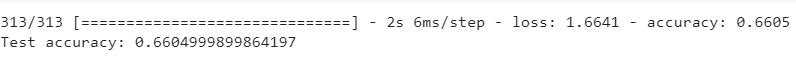

Otra forma de evaluar el modelo sería hacer una predicción. Las predicciones nos dan una estimación de cómo el modelo interpreta y categoriza nuevas instancias de datos. Según el resultado de nuestra precisión con los datos de test, nuestra red acertará un 66% de las veces. Teniendo 8 fotos, por lo tanto, nos debería acertar por lo menos 5 fotografías (8*0.66 = 5.28 -> aprox 5 fotos).

1/1 [==============================] - 0s 18ms/step


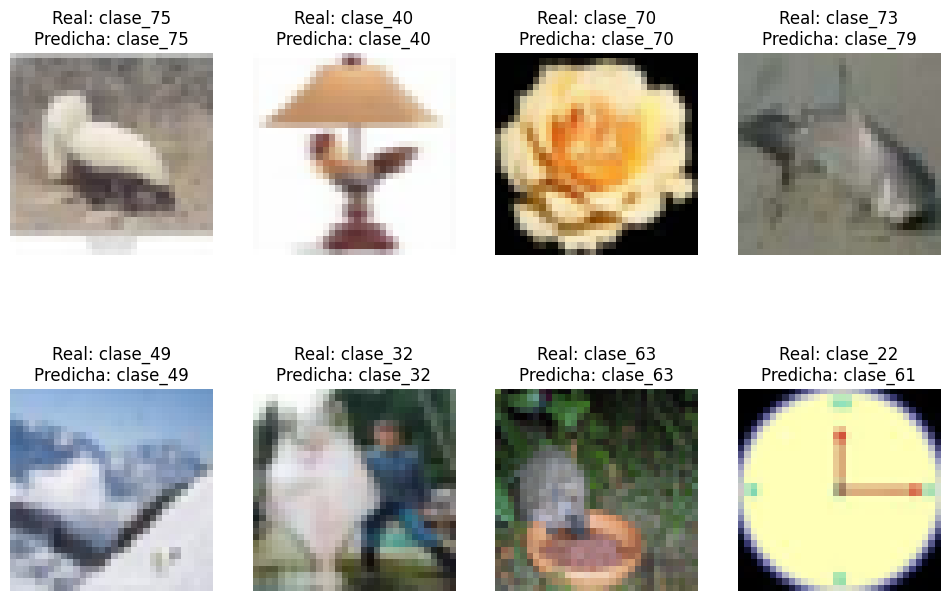

In [44]:
# Seleccionar siete índices de imágenes de prueba (ajusta según sea necesario)
sample_indices = [11, 14, 20, 35, 42, 55, 68, 79]
class_names = ['clase_{}'.format(i) for i in range(100)]

# Configurar la visualización de las imágenes en una cuadrícula de 2x4
plt.figure(figsize=(12, 8))

for i, sample_index in enumerate(sample_indices, 1):
    # Seleccionar la imagen y etiqueta correspondiente
    sample_image = test_images[sample_index]
    sample_label = test_labels_one_hot[sample_index]

    # Obtener la posición de la clase real (usando np.where)
    real_class_index = np.where(sample_label == 1)[0][0]

    # Expandir las dimensiones para que coincidan con las expectativas del modelo
    sample_image = np.expand_dims(sample_image, axis=0)

    # Obtener la predicción del modelo
    prediction = model.predict(sample_image)
    predicted_label = np.argmax(prediction)

    # Mostrar la imagen
    plt.subplot(2, 4, i)
    plt.imshow(test_images[sample_index])
    plt.title(f'Real: {class_names[real_class_index]}\nPredicha: {class_names[predicted_label]}')
    plt.axis('off')

plt.show()

Visualizamos las dos imágenes habiendo obtenido previamente los índices. Vemos que se parecen  bastante y que con una red entrenada al 66% es normal que falle al reconocerlas.

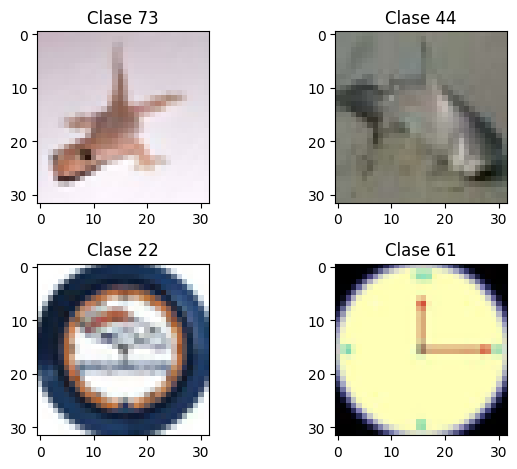

In [45]:
# Real
plt.subplot(2, 2, 1)
plt.imshow(test_images[206])
plt.title('Clase 73')

# Predicha
plt.subplot(2, 2, 2)
plt.imshow(test_images[35])
plt.title('Clase 44')

# Real
plt.subplot(2, 2, 3)
plt.imshow(test_images[45])
plt.title('Clase 22')

# Predicha
plt.subplot(2, 2, 4)
plt.imshow(test_images[79])
plt.title('Clase 61')

# Ajusta el diseño para evitar solapamiento
plt.tight_layout()

# Muestra el gráfico
plt.show()


**Análisis de la curva de aprendizaje**

Hemos creído oportuno dibujar las gráficas que reflejen la evolución del aprendizaje.

La gráfica de la izquierda nos muestra la precisión y compara los datos de entrenamiento con los de test.

La gráfica de la derecha nos muestra la pérdida y compara los datos de entrenamiento con los de test.

Podemos observar que a partir de la época 40 da un salto y aprende mucho (también baja mucho la pérdida), y se vuelve a estabilizar. Esto nos lleva a pensar que como justo en la época 40 actualizamos el learning rate y lo reducimos, la red aprende mejor y entonces la gráfica tiene menos ruido.

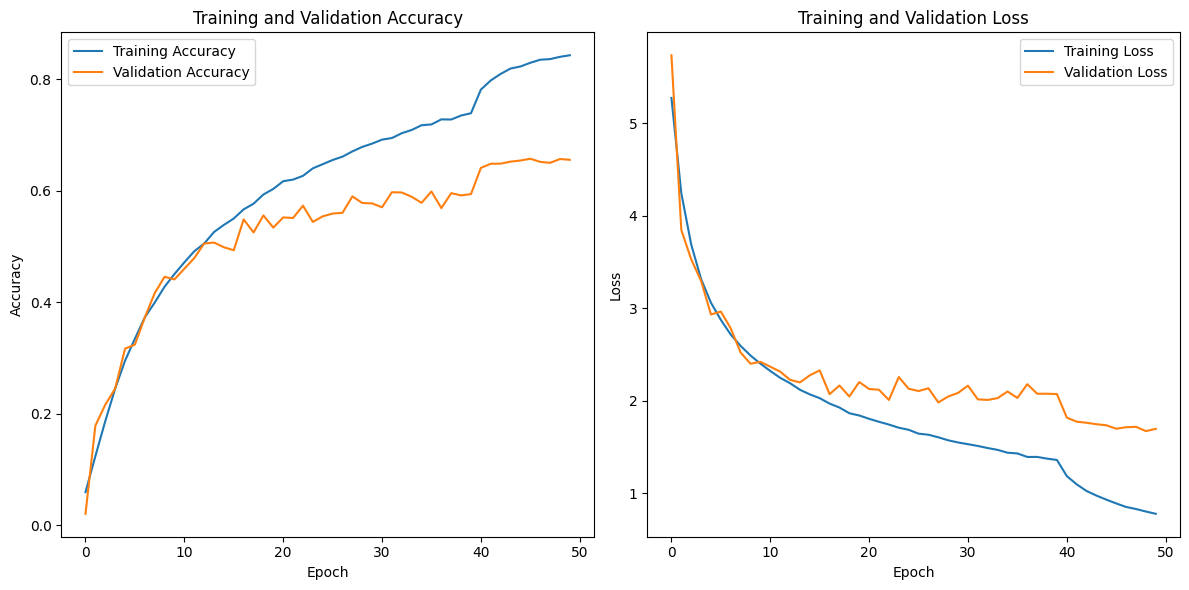

In [46]:
import matplotlib.pyplot as plt
# Visualizar la curva de aprendizaje
plt.figure(figsize=(12, 6))

# Precisión en el conjunto de entrenamiento
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Pérdida en el conjunto de entrenamiento
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

##**Conclusiones**

**Arquitectura del Modelo**

El modelo tiene una arquitectura profunda, con múltiples capas convolucionales y densas. La complejidad del modelo puede llevar a un mayor riesgo de sobreajuste, especialmente si no hay suficientes datos de entrenamiento o si el modelo no se regulariza adecuadamente.

**Data Augmentation**

Se ha aplicado la técnica de aumento de datos (ImageDataGenerator). Esto ayuda a aumentar la variabilidad en el conjunto de entrenamiento al aplicar transformaciones como rotación, desplazamiento y volteo horizontal a las imágenes. Esto generalmente mejora la capacidad del modelo para generalizar a datos no vistos.

**Regularización**

Se ha utilizado regularización L2 en las capas densas para evitar el sobreajuste al penalizar pesos grandes. Además, se ha incluido Dropout en las capas densas para introducir variabilidad durante el entrenamiento y mejorar la generalización.

**Batch Normalization**

Se ha utilizado Batch Normalization después de las capas convolucionales y densas. Esta técnica normaliza la activación de cada capa, lo que puede ayudar en la convergencia del modelo y mejorar la generalización.

**Learning Rate Schedule**

Se ha implementado un programa de tasas de aprendizaje (LearningRateScheduler) que reduce la tasa de aprendizaje durante el entrenamiento. Esto puede ser beneficioso para mejorar la convergencia del modelo a medida que avanza el entrenamiento.

**Resultados de Entrenamiento**

Hemos entrenado el modelo durante 50 épocas, y hemos observado cómo se desempeña en el conjunto de validación a lo largo del tiempo:
- Tendencia de Aprendizaje: la pérdida y la precisión (accuracy) tanto en el conjunto de entrenamiento como en el conjunto de validación se muestran durante 50 épocas. Es evidente que el modelo está aprendiendo, ya que la precisión en el conjunto de entrenamiento y validación mejora con el tiempo.
- Sobreajuste: aunque la precisión en el conjunto de entrenamiento mejora, la precisión en el conjunto de validación se estanca o incluso disminuye en algunas épocas. Esto podría indicar un cierto grado de sobreajuste, especialmente en las últimas épocas del entrenamiento.
- Data Augmentation: la técnica de aumento de datos parece haber ayudado en la generalización del modelo, ya que la precisión en el conjunto de validación ha mejorado a lo largo del tiempo.

Es decir, podemos concluir que el modelo está aprendiendo pero hay oportunidades para mejorar la generalización y la precisión en el conjunto de validación. Con el tiempo y recursos dados, esto es a lo que hemos podido llegar.

**Rendimiento en el Conjunto de Prueba**

Finalmente, el modelo se evalúa en el conjunto de prueba para medir su rendimiento en datos no vistos. Esto proporciona una indicación de la capacidad del modelo para generalizar a nuevos datos.

##**Reflexiones**

**Cómo hemos afrontado la solución de la práctica**

Tras haber entendido el código proporcionado en clase por Carlos Emilio Rabazo, hemos ido acoplando y adpatando el código a lo que se nos pedía en esta práctica. Como el entrenamiento de esta red requería un número elevado de épocas, cada uno probaba un ajuste diferente del código y luego comparábamos los resultados. Nos hemos basado en la metodología de "prueba y error" haciendo cambios que considerábamos oportunos.

Además, preguntando a otros compañeros para ir contrastando los resultados que nos daba nuestro entrenamiento de la red, hemos sido capaces de orientarnos.

**Cómo se ha dividido el trabajo**

Se decidió hacer reuniones para llevar a cabo la resolución de la práctica. Gracias a esto, se ha logrado una mayor comunicación y más facilidad para trabajar en grupo, lo cual se ha visto reflejado en el proyecto.

**Cómo se ha gestionado el equipo para trabajar**

Como hemos mencionado anteriormente, cada uno ejecutaba el código base (que sacamos al principio y que consideramos que era el que mejor funcionaba) y en base a eso íbamos realizando ajustes sobre este. Cada uno ejecutaba un ajuste y luego seguíamos modificando hiperparámetros en el que mejor precisión nos hubeira dado.